In [1]:
import rmgpy
from rmgpy.data.rmg import RMGDatabase
from rmgpy.reaction import Reaction
from rmgpy.molecule import Molecule, Bond, PeriodicSystem
from rmgpy.molecule.resonance import *

import numpy as np
import time

In [2]:
databasePath = rmgpy.settings['database.directory']

database = RMGDatabase()
database.load(
    path = databasePath,
    thermoLibraries = [],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsFamilies = ['R_Addition_MultipleBond'],
    )

In [14]:
reactants = [
    Molecule().fromAdjacencyList("""1  C u0 p0 c0 {2,B} {6,B} {7,S}
2  C u0 p0 c0 {1,B} {3,B} {8,S}
3  C u0 p0 c0 {2,B} {4,B} {9,S}
4  C u0 p0 c0 {3,B} {5,B} {10,S}
5  C u0 p0 c0 {4,B} {6,B} {11,S}
6  C u0 p0 c0 {1,B} {5,B} {12,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {2,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {5,S}
12 H u0 p0 c0 {6,S}
"""), 
    Molecule(SMILES='[H]')
]

In [15]:
rxns = database.kinetics.families['R_Addition_MultipleBond'].generateReactions(reactants)

In [18]:
rxns

[Reaction(reactants=[Molecule(SMILES="c1ccccc1"), Molecule(SMILES="[H]")], products=[Molecule(SMILES="[CH]1C=CC=CC1")], degeneracy=12, pairs=[[Molecule(SMILES="c1ccccc1"), Molecule(SMILES="[CH]1C=CC=CC1")], [Molecule(SMILES="[H]"), Molecule(SMILES="[CH]1C=CC=CC1")]])]

In [9]:
out = Molecule(SMILES='c1ccccc1').generateResonanceIsomers()

In [13]:
print out[0].toAdjacencyList()

1  C u0 p0 c0 {2,B} {6,B} {7,S}
2  C u0 p0 c0 {1,B} {3,B} {8,S}
3  C u0 p0 c0 {2,B} {4,B} {9,S}
4  C u0 p0 c0 {3,B} {5,B} {10,S}
5  C u0 p0 c0 {4,B} {6,B} {11,S}
6  C u0 p0 c0 {1,B} {5,B} {12,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {2,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {5,S}
12 H u0 p0 c0 {6,S}



multiplicity 2
1  C u0 p0 c0 {2,B-} {6,B} {7,S} {13,S}
2  C u1 p0 c0 {1,B-} {3,B} {8,S}
3  C u0 p0 c0 {2,B} {4,B} {9,S}
4  C u0 p0 c0 {3,B} {5,B} {10,S}
5  C u0 p0 c0 {4,B} {6,B} {11,S}
6  C u0 p0 c0 {1,B} {5,B} {12,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {2,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {5,S}
12 H u0 p0 c0 {6,S}
13 H u0 p0 c0 {1,S}

0.000764846801758


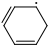

In [9]:
mol = Molecule().fromAdjacencyList("""1  C u0 p0 c0 {2,B} {6,B} {7,S}
2  C u0 p0 c0 {1,B} {3,B} {8,S}
3  C u0 p0 c0 {2,B} {4,B} {9,S}
4  C u0 p0 c0 {3,B} {5,B} {10,S}
5  C u0 p0 c0 {4,B} {6,B} {11,S}
6  C u0 p0 c0 {1,B} {5,B} {12,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {2,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {5,S}
12 H u0 p0 c0 {6,S}
13 H u1 p0 c0
""")
mol.addBond(Bond(mol.atoms[0], mol.atoms[12], order='S'))
bond = mol.getBond(mol.atoms[0], mol.atoms[1])
bond.order = 'B-'
mol.atoms[1].radicalElectrons = 1
mol.atoms[12].radicalElectrons = 0
print mol.toAdjacencyList()

t0 = time.time()
redistributeAromaticElectrons(mol)
t1 = time.time()
print t1 - t0

mol

In [5]:
def redistributeAromaticElectrons(mol):
    sssr = mol.getSmallestSetOfSmallestRings()
    if sssr == []:
        return
    
    rings = [ring for ring in sssr if len(ring) == 6]
    
    invalidRings = []
    
    for ring in rings:
        endoBonds = set()
        exoBonds = set()
        valid = True
        for atom1 in ring:
            for atom2, bond in atom1.bonds.iteritems():
                if atom2 in ring:
                    endoBonds.add(bond)
                    if bond.order == 'B+' or bond.order == 'B-':
                        valid = False
                else:
                    exoBonds.add(bond)
        if not valid:
            invalidRings.append((ring, list(endoBonds), list(exoBonds)))
    
    bondOrders = {'S': 1, 'D': 2, 'T': 3, 'B': 1.5}
    bondOrdersInv = {1: 'S', 2: 'D', 3: 'T'}
    valences = PeriodicSystem.valences
    
    for ring, endo, exo in invalidRings:
        a = []
        b = []
        for atom in ring:
            a.append([1 if atom in [bond.atom1, bond.atom2] else 0 for bond in endo])
            v = valences[atom.element.symbol]
            for bond in atom.bonds.itervalues():
                if bond in exo:
                    v -= bondOrders[bond.order]
            v -= atom.radicalElectrons
            b.append(v)
        for index, bond in enumerate(endo):
            if bond.order == 'B-':
                # Must become single bond
                new_a = [0] * len(endo)
                new_a[index] = 1
                a.append(new_a)
                b.append(1)
            elif bond.order == 'B+':
                # Must become double bond
                new_a = [0] * len(endo)
                new_a[index] = 1
                a.append(new_a)
                b.append(2)

        a = np.array(a)
        b = np.array(b)
        
        x = np.rint(np.dot(np.linalg.pinv(a), b)).tolist()
        
        for index, bond in enumerate(endo):
            bond.order = bondOrdersInv[x[index]]


In [24]:
valence - np.dot(b, y) - radicals

array([2, 2, 3, 3, 3, 3])

In [70]:
a

array([[0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0]])

In [71]:
b

array([2, 2, 3, 3, 3, 3])

In [69]:
x

array([ 1.66666667,  0.66666667,  1.33333333,  1.66666667,  1.33333333,
        1.33333333])

In [54]:
np.dot(np.linalg.pinv(a), b)

array([ 2.,  1.,  1.,  2.,  1.,  1.])

In [70]:
u, s, v = np.linalg.svd(a)
rank = (s > 1e-5*s[0]).sum()
nullspace = v[rank:]/np.min(v[rank:])

In [57]:
np.round(np.dot(u, np.dot(np.diag(s), v)), 4)

array([[-0., -0.,  1.,  1.,  0., -0.],
       [ 0., -0.,  1., -0., -0.,  1.],
       [ 0.,  1., -0., -0., -0.,  1.],
       [ 1.,  1.,  0., -0., -0.,  0.],
       [ 1., -0., -0.,  0.,  1.,  0.],
       [-0., -0.,  0.,  1.,  1., -0.]])

In [67]:
v[rank:]/np.min(v[rank:])

array([[ 1., -1., -1.,  1., -1.,  1.]])

In [76]:
x - (1./3)*nullspace

array([[ 1.,  2.,  1.,  1.,  2.,  1.]])